In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.spatial import distance_matrix
from scipy.stats import chisquare
import plotly

import wandb
from models import Discriminator, Generator, T, XYDistribution, boundary_adherence
from plotting import plot_xy, plot_xy_codes

### Dataset Generation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


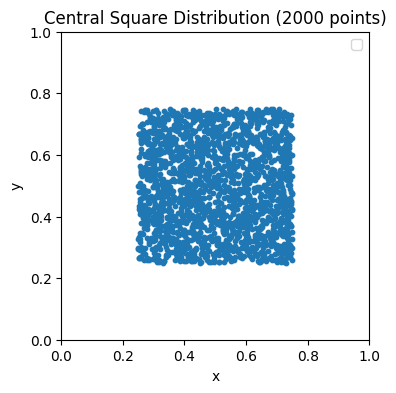

In [2]:
N_points = 2000 # From paper

np.random.seed(0)

x = np.random.uniform(low=0.25, high=0.75, size=N_points)
y = np.random.uniform(low=0.25, high=0.75, size=N_points)

# Plot the data
plt.figure(figsize=(4, 4))
plt.scatter(x, y, alpha=1, s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Central Square Distribution (2000 points)")
plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
plt.legend()
plt.show()




### Training

In [3]:
noise_size = 3
code_size = 2
beta = 0.1

net_D = Discriminator(2, 32)
net_G = Generator(noise_size + code_size, 32, 2)
net_T = T(2, code_size, 12)

batch_size = 80

dataset = XYDistribution(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size)

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.rand(2000, noise_size + code_size)

lrd = 0.0003
lrg = 0.001
lrt = 0.001
gamma_d = 0.85
gamma_g = 0.7
gamma_t = 0.7

optimizer_D = optim.Adam(net_D.parameters(), lr=lrd)
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=gamma_d)
optimizer_G = optim.Adam(net_G.parameters(), lr=lrg)
scheduler_G = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=gamma_g)
optimizer_T = optim.Adam(net_T.parameters(), lr=lrt)
scheduler_T = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=gamma_t)

NameError: name 'x' is not defined

In [37]:
d_error = []
g_error = []
t_error = []
fk_prog = []

wandb.init(
    project='InfoQGAN',
    config = {
        "Generator Architecture": str(dict(net_G.named_modules())),
        "Discriminator Architecture": str(dict(net_D.named_modules())),
        "T Architecture": str(dict(net_T.named_modules())),
        "Batch Size": batch_size
    }
)

for _ in range(300):
    for batch in dataloader:
        # First Update Discriminator with batch of Real Data
        d_loss = net_D.fit_discriminator(batch, criterion, net_G, optimizer_D, noise_size+code_size)
        g_loss = net_G.fit_generator(net_D, net_T, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)
        t_loss = net_T.fit_t(net_G, batch_size, noise_size+code_size, code_size, optimizer_T)

        d_error.append(d_loss)
        g_error.append(g_loss)
        t_error.append(t_loss)
        wandb.log({"d_loss": d_loss, "g_loss": g_loss, "t_loss": t_loss})
        # print(scheduler_D.get_lr())
    
    with torch.no_grad():
        fake = net_G(fixed_noise)
        fk_prog.append(fake)

        acc = boundary_adherence(fake.detach().numpy())
        P, D = ndtest.ks2d2s(x, y, fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy(), extra=True)
        # if P > best_p_value:
        #     best_p_value = P
        #     torch.save(net_G.state_dict(), './models/pval{P}.pth')
        wandb.log({"Accuracy": acc, "KS Test p-value": P, "KS Test value": D})
        x_c1 = np.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 0])[0][1]
        x_c2 = np.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 1])[0][1]
        y_c1 = np.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 0])[0][1]
        y_c2 = np.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 1])[0][1]
        wandb.log({"Code 0 - X axis": x_c1, "Code 1 - X axis": x_c2, "Code 0 - Y axis": y_c1, "Code 1 - Y axis": y_c2,})
        # print(P)

    if _ % 50 == 0:
        with torch.no_grad():
            clear_output(wait=True)
            fig = plot_xy(fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy())
            # img = wandb.Image(fig)
            # wandb.log({"Generator Output": img})

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


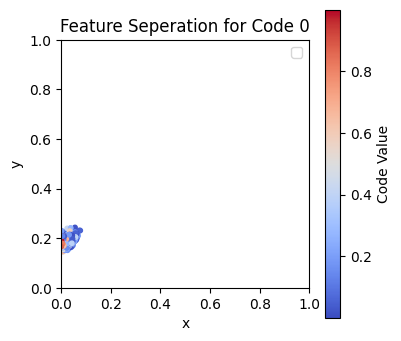

In [4]:
rand_inp = torch.rand((2000, noise_size+code_size))

gen_output = net_G(rand_inp)

x_test = gen_output[:, 0].detach().numpy()
y_test = gen_output[:, 1].detach().numpy()


plot_xy_codes(gen_output[:, 0].detach().numpy(), gen_output[:, 1].detach().numpy(), 0, rand_inp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


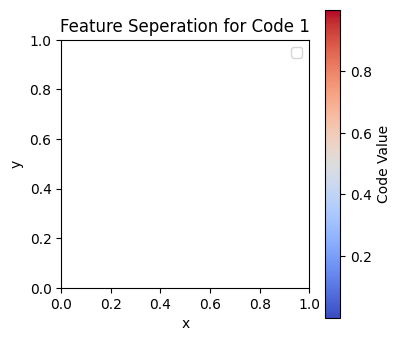

In [7]:
plot_xy_codes(gen_output[:, 0].detach().numpy(), gen_output[:, 1].detach().numpy(), 1, rand_inp)

In [ ]:
torch.save(net_G.state_dict(), './models/captain-cube-35.pth')